<a href="https://colab.research.google.com/github/Pranjalya/sex-predator-detection/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/My\ Drive/sih_project

/content/drive/My Drive/sih_project


## Data Cleaning and some Preprocessing

In [ ]:
import pandas as pd
train = pd.read_csv('train_inclusive.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903607 entries, 0 to 903606
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   @id                    903607 non-null  object
 1   @line                  903607 non-null  int64 
 2   author                 903607 non-null  object
 3   time                   903607 non-null  object
 4   text                   900628 non-null  object
 5   sexual_predator        903607 non-null  int64 
 6   predator_conversation  903607 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 48.3+ MB


In [ ]:
train['predator_conversation'].value_counts()

0    824276
1     79331
Name: predator_conversation, dtype: int64

Removing texts with NaN values

In [ ]:
train.dropna(subset = ['text'], inplace = True)
train.index = range(0, train.shape[0])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900628 entries, 0 to 900627
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   @id                    900628 non-null  object
 1   @line                  900628 non-null  int64 
 2   author                 900628 non-null  object
 3   time                   900628 non-null  object
 4   text                   900628 non-null  object
 5   sexual_predator        900628 non-null  int64 
 6   predator_conversation  900628 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 48.1+ MB


In [ ]:
print("No of sexual predators : {}".format(train[train['sexual_predator']==1]['author'].nunique()))
print("No of users : {}".format(train['author'].nunique()))
print("No of total conversations : {}".format(train['@id'].nunique()))

No of sexual predators : 142
No of users : 97671
No of total conversations : 66914


In [ ]:
!pip install emot
!pip install contractions

In [ ]:
import re
import contractions
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
ps = PorterStemmer()
stop_words = stopwords.words('english')
pattern = r"[$&+,:;=_?@#|\[\]{}'<>.^*()%!-]"

def clean_text(text):
    '''
    Lambda function to clean text
    '''
    # Replacing emoji to word
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    # Replacing emoticons to words
    for emot in EMOTICONS:
        text = re.sub(r'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    # Remove url
    text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', "", text)
    # Removing punctuation
    text = ' '.join(re.sub(pattern, '', text).strip().split())
    # Removing numbers
    text = ' '.join([word for word in text.split() if word.isalpha()])
    text = text.lower()
    # Useful library to expand the contractions
    text = contractions.fix(text)
    # Strip symbols
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Stopword removal
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # Stemming 
    text = ' '.join([ps.stem(word) for word in text.split()])

    return text

In [ ]:
%%timeit
train['text'] = train['text'].apply(clean_text)

1 loop, best of 3: 29min 53s per loop


In [ ]:
train.head()

,@id,@line,author,time,text,sexual_predator,predator_conversation
0,0000604306a283600b730276a2039471,1,a9b326df4e6da61c5b6f5e1058be83a2,13:04,set test case nonconform,0,0
1,0000604306a283600b730276a2039471,2,b8810fee2f4a71f849f3f7409546d1d9,13:12,syntax modul,0,0
2,0000604306a283600b730276a2039471,3,b8810fee2f4a71f849f3f7409546d1d9,13:12,also use ann wf test use test har broken,0,0
3,0000604306a283600b730276a2039471,4,b8810fee2f4a71f849f3f7409546d1d9,13:13,spec stabil make sen write test,0,0
4,0000604306a283600b730276a2039471,5,a9b326df4e6da61c5b6f5e1058be83a2,13:19,btw good estim mani man hour put work conform ...,0,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900628 entries, 0 to 900627
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   @id                    900628 non-null  object
 1   @line                  900628 non-null  int64 
 2   author                 900628 non-null  object
 3   time                   900628 non-null  object
 4   text                   900628 non-null  object
 5   sexual_predator        900628 non-null  int64 
 6   predator_conversation  900628 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 48.1+ MB


In [ ]:
train.to_csv('cleaned.csv', index=False)

## Some Analysis

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def gen_freq(text):
    word_list = []
    for words in text.split():
        word_list.extend(words)
    word_freq = pd.Series(word_list).value_counts()
    return word_freq

word_freq_normal = gen_freq(train[train['sexual_predator'] == 0]['text'].str)
word_freq_predator = gen_freq(train[train['sexual_predator'] == 1]['text'].str)
stop_words = stopwords.words('english')

Word Cloud for non-predatory conversations

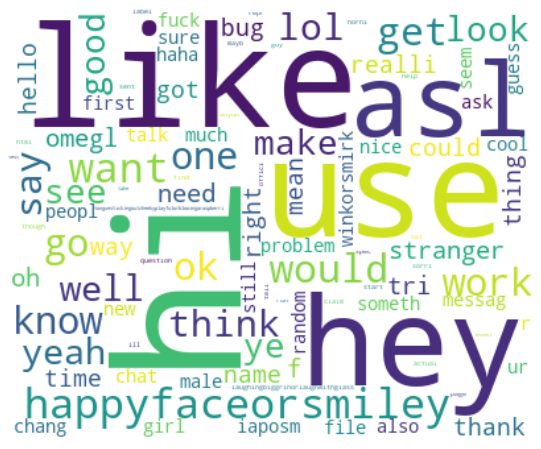

In [ ]:
wc_normal = WordCloud(width = 400, height = 330, max_words = 100, 
                      background_color = 'white', stopwords = stop_words).generate_from_frequencies(word_freq_normal)
plt.figure(figsize = (12, 8))
plt.imshow(wc_normal, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Word Cloud for predatory conversations

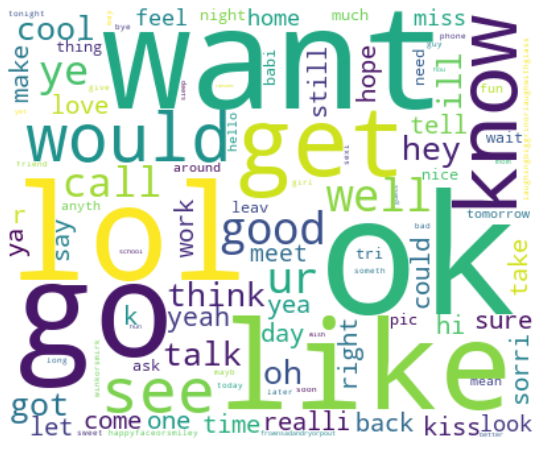

In [ ]:
wc_predator = WordCloud(width = 400, height = 330, max_words = 100, 
                        background_color = 'white', stopwords = stop_words).generate_from_frequencies(word_freq_predator)

plt.figure(figsize = (12, 8))
plt.imshow(wc_predator, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
sns.countplot(train['sexual_predator'])
plt.show()

In [ ]:
!wget -O stopwords.txt https://gist.githubusercontent.com/larsyencken/1440509/raw/53273c6c202b35ef00194d06751d8ef630e53df2/stopwords.txt

--2020-07-11 13:07:49--  https://gist.githubusercontent.com/larsyencken/1440509/raw/53273c6c202b35ef00194d06751d8ef630e53df2/stopwords.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2631 (2.6K) [text/plain]
Saving to: ‘stopwords.txt’

stopwords.txt       100%[===================>]   2.57K  --.-KB/s    in 0.001s  

2020-07-11 13:07:49 (2.66 MB/s) - ‘stopwords.txt’ saved [2631/2631]



In [ ]:
!sed -i -e 1,6d stopwords.txt
!head stopwords.txt

a
about
above
across
after
again
against
all
almost
alone


Let's remove some more general stopwords, which appear in normal conversations.

In [ ]:
with open('stopwords.txt') as f:
    more_stop_words = f.readlines()

more_stop_words = list(map(lambda x: x.rstrip('\n'), more_stop_words))

def cleaning_more_stopwords(text):
    return ' '.join(word for word in text.split() if word not in more_stop_words)

In [ ]:
train['text'] = train['text'].apply(cleaning_more_stopwords)

In [ ]:
word_freq_normal = gen_freq(train[train['sexual_predator'] == 0]['text'].str)
word_freq_predator = gen_freq(train[train['sexual_predator'] == 1]['text'].str)

Normal conversation Word Cloud

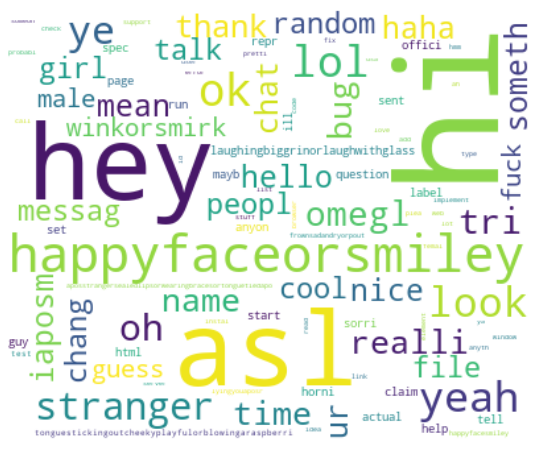

In [ ]:
wc_normal = WordCloud(width = 400, height = 330, max_words = 100, 
                      background_color = 'white', stopwords = more_stop_words).generate_from_frequencies(word_freq_normal)
plt.figure(figsize = (12, 8))
plt.imshow(wc_normal, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Predatory conversation Word Cloud

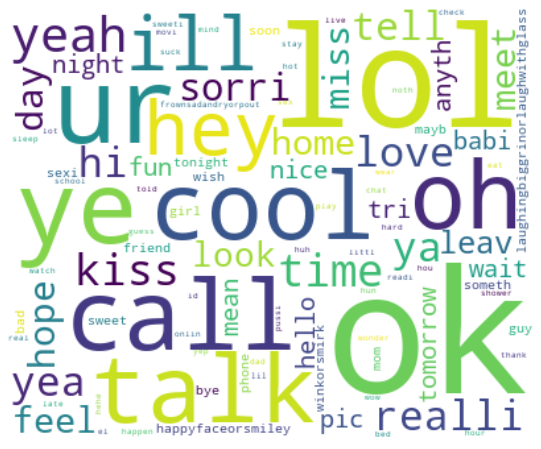

In [ ]:
wc_predator = WordCloud(width = 400, height = 330, max_words = 100, 
                        background_color = 'white', stopwords = more_stop_words).generate_from_frequencies(word_freq_predator)

plt.figure(figsize = (12, 8))
plt.imshow(wc_predator, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
train.to_csv('more_cleaned.csv', index=False)